 # Blockchain Fraud Detection using Graph Neural Networks

 **Project Overview:**

 In this notebook, we implement a Graph Convolutional Network (GCN) model to detect fraudulent Bitcoin transactions using the Elliptic dataset. The dataset maps Bitcoin transactions (nodes) to their corresponding classes (licit or illicit), and edges represent Bitcoin flows between transactions.

 **Main Features:**

 - **Data Loading & Cleaning:**
   Load the dataset, remove low-variance features, and visualize the target distribution.

 - **Multiple Data Splitting Strategies:**
   - **Time-step Split:** Create subgraphs for each time step.
   - **Time-group Split:** Merge consecutive time steps into single graphs.
   - **Random Split (Transductive & Inductive):** Split nodes randomly while either preserving the entire graph (transductive) or keeping only intra-set edges (inductive).
   - **Community-based Split:** Use spectral clustering and K-Means to cluster nodes and split by community.

 - **A GCN Model:**
   A multi-layer GCN with residual connections, batch normalization, dropout, and a learning rate scheduler.

 - **Training & Evaluation:**
   Train with early stopping and checkpointing. Evaluate using classification reports, AUC-ROC scores, confusion matrices, and loss curves.

 **Usage:**

 1. Place the Elliptic dataset CSV files (`nodes.csv` and `edges.csv`) into a `data/` folder.
 2. Run this notebook cell-by-cell (or use "Run All").
 3. The best model checkpoint is saved as `best_advanced_gcn_model.pt`.

 **Dependencies:**
 See the `requirements.txt` for a list of required packages.

 ## 1. Setup and Install Dependencies

 **Note:** If you are running this notebook on a platform like Kaggle or Colab, you may need to install some packages. Uncomment the pip install commands below if required.

In [ ]:
# Uncomment the following if packages are not installed:
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install torch-geometric


 ## 2. Import Libraries and Set Device

In [1]:
import os
import copy
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'axes.facecolor':'dimgrey', 'grid.color':'lightgrey'})
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import add_self_loops, degree

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.cluster import KMeans
import scipy.sparse as scsp

# Set device: use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)


Using device: cpu


 ## 3. Data Loading and Cleaning

 In this section, we load the nodes and edges CSV files from the `data/` folder and perform basic cleaning (e.g., drop low-variance columns).

In [2]:
def load_elliptic_data(nodes_path, edges_path):
    """
    Loads the nodes and edges CSV files.
    """
    df_nodes = pd.read_csv(nodes_path)
    df_edges = pd.read_csv(edges_path)
    print("Nodes shape:", df_nodes.shape)
    print("Edges shape:", df_edges.shape)
    return df_nodes, df_edges

# Set file paths (adjust as needed)
nodes_path = os.path.join("data", "nodes.csv")
edges_path = os.path.join("data", "edges.csv")
df_nodes, df_edges = load_elliptic_data(nodes_path, edges_path)


Nodes shape: (46564, 168)
Edges shape: (36624, 2)


In [3]:
# Display basic info and drop low-variance columns
df_nodes.info()

# Inspect columns with very few unique values
for col in df_nodes.columns:
    if df_nodes[col].nunique() < 10:
        print(f"Column {col} unique counts:")
        print(df_nodes[col].value_counts())
        print("-" * 30)

# Drop example column "16" if it exists (low variance)
if "16" in df_nodes.columns:
    df_nodes.drop("16", axis=1, inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46564 entries, 0 to 46563
Columns: 168 entries, txId to 166
dtypes: float64(165), int64(3)
memory usage: 59.7 MB
Column class unique counts:
class
0    42019
1     4545
Name: count, dtype: int64
------------------------------
Column 4 unique counts:
4
-1.201369    15372
 1.018602    13196
 0.463609     8037
 1.573595     4923
-0.091383     3258
-0.646376     1015
 2.128587      704
-1.756361       48
 2.683580       11
Name: count, dtype: int64
------------------------------
Column 16 unique counts:
16
-0.013282    46533
 0.159894       26
 0.679419        2
 1.372120        1
 0.333069        1
 0.506244        1
Name: count, dtype: int64
------------------------------
Column 113 unique counts:
113
-1.096336    18017
 1.023860     9162
 0.493811     5993
-0.036238     3394
 1.553909     3377
 2.083958     2987
-1.626385     2136
-0.566287     1482
 2.614007       16
Name: count, dtype: int64
------------------------------
Column 114 un

 ### Visualize Target Distribution

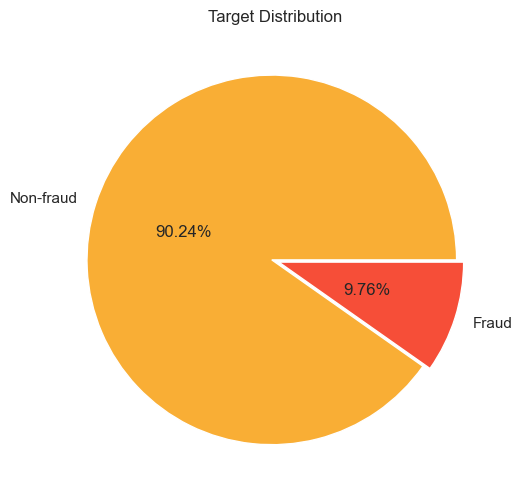

In [4]:
plt.figure(figsize=(8,6))
labels = ['Non-fraud', 'Fraud']
colors = ['#f9ae35', '#f64e38']
plt.pie(df_nodes['class'].value_counts(), labels=labels, autopct='%.2f%%',
        explode=[0.02, 0.02], colors=colors, pctdistance=0.5)
plt.title("Target Distribution")
plt.show()


 ## 4. Data Splitting Functions

 We define multiple functions to split the graph data. The splits are based on time steps, groups of time steps, random node splits (transductive and inductive), and community-based clustering.

In [5]:
def time_step_split_support(nodes, edges):
    """
    Split nodes by time step and create corresponding subgraphs.
    """
    features = torch.FloatTensor(nodes.iloc[:, 2:].to_numpy())
    times = torch.LongTensor(nodes.iloc[:, 2].to_numpy().reshape(-1))
    labels = torch.LongTensor(nodes.iloc[:, 1].to_numpy().reshape(-1))
    nodes_id = torch.LongTensor(nodes.iloc[:, 0].to_numpy().reshape(-1))
    
    min_t, max_t = int(times.min()), int(times.max())
    features_t, labels_t = [], []
    id2idx = {}
    for t in range(min_t, max_t+1):
        idx_t = (times == t).nonzero(as_tuple=True)[0]
        features_t.append(features[idx_t])
        labels_t.append(labels[idx_t])
        for i, node in enumerate(nodes_id[times == t]):
            id2idx[int(node.item())] = {'idx': i, 't': t}
    
    edge_idx_t = [[] for _ in range(min_t, max_t+1)]
    for i in range(edges.shape[0]):
        n1 = int(edges.iloc[i, 0])
        n2 = int(edges.iloc[i, 1])
        t = id2idx[n1]['t']
        i1 = id2idx[n1]['idx']
        i2 = id2idx[n2]['idx']
        edge_idx_t[t-1].append([i1, i2])
    edge_indices = [torch.LongTensor(edge).t() if len(edge) > 0 else torch.empty((2, 0), dtype=torch.long)
                    for edge in edge_idx_t]
    return features_t, edge_indices, labels_t

def time_step_split(nodes, edges, device, train_lt=31, val_lt=36, test_lt=49):
    """
    Splits the data by time step into train, validation, and test sets.
    """
    features_t, edge_indices, labels_t = time_step_split_support(nodes, edges)
    graph_info = np.array([[t+1, features_t[t].shape[0],
                             edge_indices[t].shape[1] if edge_indices[t].ndim > 0 else 0,
                             (labels_t[t]==1).sum().item()] for t in range(len(labels_t))])
    
    train_list = [Data(x=features_t[i], edge_index=edge_indices[i], y=labels_t[i]).to(device)
                  for i in range(train_lt)]
    val_list = [Data(x=features_t[i], edge_index=edge_indices[i], y=labels_t[i]).to(device)
                for i in range(train_lt, val_lt)]
    test_list = [Data(x=features_t[i], edge_index=edge_indices[i], y=labels_t[i]).to(device)
                 for i in range(val_lt, test_lt)]
    data = {'train': train_list, 'val': val_list, 'test': test_list}
    return data, graph_info

def time_group_split(nodes, edges, device, train_lt=31, val_lt=36, test_lt=49):
    """
    Merges nodes from specified time steps into unified train, validation, and test sets.
    """
    features = torch.FloatTensor(nodes.iloc[:, 2:].to_numpy())
    times = torch.LongTensor(nodes.iloc[:, 2].to_numpy().reshape(-1))
    labels = torch.LongTensor(nodes.iloc[:, 1].to_numpy().reshape(-1))
    nodes_id = torch.LongTensor(nodes.iloc[:, 0].to_numpy().reshape(-1))
    
    data_names = {'train': np.arange(1, train_lt+1),
                  'val': np.arange(train_lt+1, val_lt+1),
                  'test': np.arange(val_lt+1, test_lt+1)}
    raw_data = {}
    id2idx = {}
    for name, ts in data_names.items():
        feat_list, label_list, id_list = [], [], []
        for t in ts:
            mask = (times == t)
            feat_list.append(features[mask])
            label_list.append(labels[mask])
            id_list.append(nodes_id[mask])
        feat_cat = torch.cat(feat_list, 0)
        label_cat = torch.cat(label_list, 0)
        id_cat = torch.cat(id_list, 0)
        raw_data[name] = {'features': feat_cat, 'labels': label_cat}
        for i, node in enumerate(id_cat):
            id2idx[int(node.item())] = {'idx': i, 'set': name}
    
    edge_idx_set = {name: [] for name in data_names.keys()}
    for i in range(edges.shape[0]):
        n1 = int(edges.iloc[i, 0])
        n2 = int(edges.iloc[i, 1])
        if n1 in id2idx and n2 in id2idx:
            set1, set2 = id2idx[n1]['set'], id2idx[n2]['set']
            if set1 == set2:
                edge_idx_set[set1].append([id2idx[n1]['idx'], id2idx[n2]['idx']])
    
    data = {}
    for name in data_names.keys():
        edge_index = (torch.LongTensor(edge_idx_set[name]).t() if len(edge_idx_set[name]) > 0 
                      else torch.empty((2, 0), dtype=torch.long))
        data[name] = Data(x=raw_data[name]['features'], edge_index=edge_index, y=raw_data[name]['labels']).to(device)
    return data

def random_split_transd(nodes, edges, train_size, test_size, device, seed=42):
    """
    Randomly splits nodes (transductively) while keeping the entire graph structure.
    """
    features = torch.FloatTensor(nodes.iloc[:, 2:].to_numpy())
    labels = torch.LongTensor(nodes.iloc[:, 1].to_numpy().reshape(-1))
    
    id2idx = {nodes.iloc[i, 0]: i for i in range(nodes.shape[0])}
    edge_idx = np.zeros((2, edges.shape[0]), dtype=np.int64)
    for i in range(edges.shape[0]):
        edge_idx[:, i] = [id2idx[edges.iloc[i, 0]], id2idx[edges.iloc[i, 1]]]
    edge_index = torch.LongTensor(edge_idx)
    
    all_idx = np.arange(labels.shape[0])
    train_idx, temp_idx = train_test_split(all_idx, test_size=1 - train_size, random_state=seed)
    val_idx, test_idx = train_test_split(temp_idx, test_size=test_size/(1-train_size), random_state=seed)
    
    data = Data(x=features, edge_index=edge_index, y=labels).to(device)
    return data, {'train': train_idx, 'val': val_idx, 'test': test_idx}

def random_split_ind(nodes, edges, train_size, test_size, device, seed=42):
    """
    Randomly splits nodes (inductively) and builds induced subgraphs (only intra-set edges).
    """
    features = torch.FloatTensor(nodes.iloc[:, 2:].to_numpy())
    labels = torch.LongTensor(nodes.iloc[:, 1].to_numpy().reshape(-1))
    nodes_id = torch.LongTensor(nodes.iloc[:, 0].to_numpy().reshape(-1))
    
    all_idx = np.arange(nodes_id.shape[0])
    train_idx, temp_idx = train_test_split(all_idx, test_size=1-train_size, random_state=seed)
    val_idx, test_idx = train_test_split(temp_idx, test_size=test_size/(1-train_size), random_state=seed)
    
    splits = {'train': train_idx, 'val': val_idx, 'test': test_idx}
    data = {}
    for key in splits:
        mask = np.zeros(nodes_id.shape[0], dtype=bool)
        mask[splits[key]] = True
        edge_list = []
        for i in range(edges.shape[0]):
            n1, n2 = edges.iloc[i, 0], edges.iloc[i, 1]
            if (n1 in nodes_id.numpy()) and (n2 in nodes_id.numpy()):
                idx1 = np.where(nodes_id.numpy() == n1)[0][0]
                idx2 = np.where(nodes_id.numpy() == n2)[0][0]
                if mask[idx1] and mask[idx2]:
                    edge_list.append([idx1, idx2])
        if len(edge_list) == 0:
            edge_index = torch.empty((2, 0), dtype=torch.long)
        else:
            edge_index = torch.LongTensor(edge_list).t()
        data[key] = Data(x=features[splits[key]], edge_index=edge_index, y=labels[splits[key]]).to(device)
    return data

def laplacian(A, alpha=0.1):
    """
    Compute the modified Laplacian matrix for spectral clustering.
    """
    A = (1-alpha)*(A+A.T) + alpha * scsp.csr_matrix(np.outer(np.ones(A.shape[0]), np.ones(A.shape[0])))
    D = scsp.diags(np.asarray(A.sum(axis=0)).reshape(-1) ** (-0.5))
    L = scsp.eye(A.shape[0]) - D @ A @ D
    return L

def adj_list_to_mtx(n, edge_index):
    """
    Converts an edge index into a sparse CSR-format adjacency matrix.
    """
    mtx = np.zeros((n, n))
    for i in range(edge_index.shape[1]):
        u = int(edge_index[0, i])
        v = int(edge_index[1, i])
        mtx[u, v] = 1
    return scsp.csr_matrix(mtx)

def nearest_sum(arr, target):
    """
    Given an array, select a subset whose sum is nearest to target.
    Returns the residual and the indices of the selected subset.
    """
    n = len(arr)
    dp = np.zeros((n+1, target+1), dtype=bool)
    dp[0, 0] = True
    for i in range(1, n+1):
        for j in range(target+1):
            dp[i, j] = dp[i-1, j]
            if j >= arr[i-1] and dp[i-1, j-arr[i-1]]:
                dp[i, j] = True
    t = target
    while t >= 0 and not dp[n, t]:
        t -= 1
    selected = []
    i = n
    while i > 0 and t > 0:
        if t >= arr[i-1] and dp[i-1, t-arr[i-1]]:
            selected.append(i-1)
            t -= arr[i-1]
        i -= 1
    return target - (target-t), selected

def community_split_transd(nodes, edges, train_size, test_size, device):
    """
    Splits the full graph into train/val/test sets based on community structure.
    Uses spectral clustering to group nodes into clusters.
    """
    cluster_num = 500
    features_t, edge_indices, _ = time_step_split_support(nodes, edges)
    features = torch.FloatTensor(nodes.iloc[:, 2:].to_numpy())
    labels = torch.LongTensor(nodes.iloc[:, 1].to_numpy().reshape(-1))
    nodes_id = nodes.iloc[:, 0].to_numpy()
    
    id2idx = {nodes.iloc[i, 0]: i for i in range(nodes.shape[0])}
    edge_idx = np.zeros((2, edges.shape[0]), dtype=np.int64)
    for i in range(edges.shape[0]):
        edge_idx[:, i] = [id2idx[edges.iloc[i, 0]], id2idx[edges.iloc[i, 1]]]
    edge_index = torch.LongTensor(edge_idx)
    
    eval_dict = {}
    node_num = []
    for t in range(49):
        n = features_t[t].shape[0]
        A = adj_list_to_mtx(n, edge_indices[t])
        L = laplacian(A)
        k = max(2, n // 40)
        evals, evecs = scsp.linalg.eigsh(L, k=k, which='SM')
        for i in range(evals.shape[0]):
            eval_dict[evals[i]] = [t, i, evecs[:, i]]
        node_num.append(n)
    node_blk = np.insert(np.cumsum(node_num), 0, 0)
    all_evals = np.sort(np.array(list(eval_dict.keys())))
    small_evals = all_evals[49:49+cluster_num]
    node_mtx = np.zeros((node_blk[-1], cluster_num))
    for i, eval_val in enumerate(small_evals):
        t, _, evec = eval_dict[eval_val]
        node_mtx[node_blk[t]:node_blk[t+1], i] = evec
    kmeans = KMeans(n_clusters=cluster_num, init='random', random_state=42,
                    n_init=3, max_iter=10).fit(node_mtx)
    comm_count = np.bincount(kmeans.labels_)
    
    node_sum = nodes.shape[0]
    train_num = int(np.round(node_sum * train_size))
    val_num = int(np.round(node_sum * (1 - train_size - test_size)))
    
    _, train_clust_idx = nearest_sum(comm_count, train_num)
    remaining_counts = np.delete(comm_count, train_clust_idx)
    remaining_clust = np.delete(np.arange(cluster_num), train_clust_idx)
    _, val_clust_idx_tmp = nearest_sum(remaining_counts, val_num)
    val_clust_idx = remaining_clust[val_clust_idx_tmp]
    test_clust_idx = np.setdiff1d(np.arange(cluster_num), np.concatenate((train_clust_idx, val_clust_idx)))
    
    train_idx, val_idx, test_idx = [], [], []
    for i, lbl in enumerate(kmeans.labels_):
        if lbl in train_clust_idx:
            train_idx.append(i)
        elif lbl in val_clust_idx:
            val_idx.append(i)
        else:
            test_idx.append(i)
    train_idx = np.array(train_idx)
    val_idx = np.array(val_idx)
    test_idx = np.array(test_idx)
    data_out = Data(x=features, edge_index=edge_index, y=labels).to(device)
    return data_out, {'train': train_idx, 'val': val_idx, 'test': test_idx}


 ## 5. Advanced GCN Model Definition

 We now define our advanced GCN model with:

 - A first layer that maps input features to a hidden dimension.
 - Multiple intermediate layers with batch normalization, ReLU activation, dropout, and optional residual connections.
 - An output layer that maps to the number of classes (here, 2).
 - A final LogSoftmax activation.

 The custom GCN layers extend PyG’s `MessagePassing` class with proper normalization and self-loop support.

In [6]:
class AdvancedGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.5, residual=True):
        """
        Advanced GCN model with residual connections.
        """
        super(AdvancedGCN, self).__init__()
        self.num_layers = num_layers
        self.residual = residual
        self.dropout = dropout
        
        # First layer
        self.gcn_in = GCNLayer(input_dim, hidden_dim, directed=False)
        # Intermediate layers
        self.gcn_layers = nn.ModuleList([GCNLayer(hidden_dim, hidden_dim, directed=False)
                                         for _ in range(num_layers - 2)])
        self.bns = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for _ in range(num_layers - 2)])
        # Output layer
        self.gcn_out = GCNLayer(hidden_dim, output_dim, directed=False)
        self.log_softmax = nn.LogSoftmax(dim=-1)
    
    def reset_parameters(self):
        self.gcn_in.reset_parameters()
        for layer in self.gcn_layers:
            layer.reset_parameters()
        self.gcn_out.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()
    
    def forward(self, x, edge_index):
        x_in = self.gcn_in(x, edge_index, torch.ones(edge_index.shape[1]).to(x.device))
        x = F.relu(x_in)
        x = F.dropout(x, p=self.dropout, training=self.training)
        for i, layer in enumerate(self.gcn_layers):
            x_prev = x
            x = layer(x, edge_index, torch.ones(edge_index.shape[1]).to(x.device))
            x = self.bns[i](x)
            x = F.relu(x)
            if self.residual:
                x = x + x_prev
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gcn_out(x, edge_index, torch.ones(edge_index.shape[1]).to(x.device))
        return self.log_softmax(x)

class GCNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels, bias=True, directed=False, self_loop=True, **kwargs):
        """
        Basic GCN layer with self-loop support and symmetric normalization.
        """
        super(GCNLayer, self).__init__(aggr='add', **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.directed = directed
        self.self_loop = self_loop
        self.lin = nn.Linear(in_channels, out_channels, bias=bias)
        self.reset_parameters()
    
    def reset_parameters(self):
        self.lin.reset_parameters()
    
    def forward(self, x, edge_index, edge_weight):
        if self.self_loop:
            edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
            edge_weight = torch.cat((edge_weight, torch.ones(x.size(0)).to(x.device)), dim=0)
        x = self.lin(x)
        if self.directed:
            row, _ = edge_index
            deg = degree(row, x.size(0), dtype=x.dtype)
            norm = deg.pow(-1)[row]
        else:
            row, col = edge_index
            deg = degree(col, x.size(0), dtype=x.dtype)
            deg_inv_sqrt = deg.pow(-0.5)
            norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        return self.propagate(edge_index, x=x, norm=norm, edge_weight=edge_weight)
    
    def message(self, x_j, norm, edge_weight):
        return norm.view(-1, 1) * x_j * edge_weight.view(-1, 1)


 ## 6. Training and Evaluation Functions

 We define functions for:

 - **train_epoch:** Performs one epoch of training (supports transductive, inductive, or time-step splits).
 - **evaluate:** Computes evaluation metrics (classification report, AUC-ROC).
 - **plot_loss_curve:** Plots the training loss over epochs.

In [7]:
def train_epoch(model, data, optimizer, loss_fn, split='transd', split_idx=None):
    """
    Trains the model for one epoch.
    """
    model.train()
    optimizer.zero_grad()
    if split == 'transd':
        out = model(data.x, data.edge_index)
        loss = loss_fn(out[split_idx['train']], data.y[split_idx['train']])
    elif split == 'ind':
        out = model(data.x, data.edge_index)
        loss = loss_fn(out, data.y)
    elif split == 'time-step':
        losses = []
        for d in data['train']:
            out = model(d.x, d.edge_index)
            losses.append(loss_fn(out, d.y))
        loss = torch.stack(losses).mean()
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate(model, data, split='transd', split_idx=None):
    """
    Evaluates the model and returns metrics.
    """
    model.eval()
    if split == 'transd':
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=-1)
        y_true_train = data.y[split_idx['train']]
        y_pred_train = pred[split_idx['train']]
        y_true_val = data.y[split_idx['val']]
        y_pred_val = pred[split_idx['val']]
        y_true_test = data.y[split_idx['test']]
        y_pred_test = pred[split_idx['test']]
        metrics = {
            'train': classification_report(y_true_train.cpu(), y_pred_train.cpu(), zero_division=0, output_dict=True),
            'val': classification_report(y_true_val.cpu(), y_pred_val.cpu(), zero_division=0, output_dict=True),
            'test': classification_report(y_true_test.cpu(), y_pred_test.cpu(), zero_division=0, output_dict=True),
            'train_auc': roc_auc_score(y_true_train.cpu(), y_pred_train.cpu()),
            'val_auc': roc_auc_score(y_true_val.cpu(), y_pred_val.cpu()),
            'test_auc': roc_auc_score(y_true_test.cpu(), y_pred_test.cpu())
        }
    elif split == 'ind':
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=-1)
        metrics = classification_report(data.y.cpu(), pred.cpu(), zero_division=0, output_dict=True)
    elif split == 'time-step':
        metrics = {'train': [], 'val': [], 'test': []}
        for key in ['train', 'val', 'test']:
            reports = []
            auc_sum = 0
            for d in data[key]:
                out = model(d.x, d.edge_index)
                pred = out.argmax(dim=-1)
                reports.append(classification_report(d.y.cpu(), pred.cpu(), zero_division=0, output_dict=True))
                auc_sum += roc_auc_score(d.y.cpu(), pred.cpu())
            metrics[key + '_auc'] = auc_sum / len(data[key])
            metrics[key] = reports
    return metrics

def plot_loss_curve(losses, title="Training Loss Curve"):
    """
    Plots the loss curve.
    """
    plt.figure(figsize=(8,6))
    plt.plot(losses, marker='o', color='dodgerblue')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()


 ## 7. Main Training Routine

 In the main routine we:

 - Choose a splitting strategy (transductive, inductive, or time-step).
 - Prepare the data accordingly (using either random split or community-based split).
 - Initialize hyperparameters, the model, optimizer, scheduler, and loss function.
 - Train the model with early stopping.
 - Evaluate on the test set (if applicable) and plot the loss curve and confusion matrix.
 - Save the best model checkpoint.

In [8]:
def main():
    # Choose a splitting strategy: 'transd', 'ind', or 'time-step'
    split_method = 'transd'
    
    # Determine approximate train/test proportions based on time-step split
    _, graph_info = time_step_split(df_nodes, df_edges, device)
    node_sum = df_nodes.shape[0]
    train_node_size = np.sum(graph_info[:31, 1]) / node_sum
    test_node_size = np.sum(graph_info[36:, 1]) / node_sum

    # Option 1: Transductive random split
    data_transd, split_idx_transd = random_split_transd(df_nodes, df_edges, train_node_size, test_node_size, device)
    # Option 2: Community-based split (transductive)
    data_comm, split_idx_comm = community_split_transd(df_nodes, df_edges, train_node_size, test_node_size, device)
    
    # Select which data to use
    if split_method == 'transd':
        data_used, current_split = data_comm, split_idx_comm  # You can change to data_transd if desired
    elif split_method == 'ind':
        data_used = time_group_split(df_nodes, df_edges, device)
        current_split = None
    elif split_method == 'time-step':
        data_used, _ = time_step_split(df_nodes, df_edges, device)
        current_split = None

    # Hyperparameters
    args = {
        'num_layers': 3,
        'hidden_dim': 256,
        'dropout': 0.5,
        'lr': 0.01,
        'epochs': 50,
        'patience': 10  # Early stopping patience
    }
    
    if split_method in ['transd', 'ind']:
        input_dim = data_used.x.shape[1]
    else:
        input_dim = data_used['train'][0].x.shape[1]
    
    model = AdvancedGCN(input_dim, args['hidden_dim'], output_dim=2,
                        num_layers=args['num_layers'], dropout=args['dropout'], residual=True).to(device)
    model.reset_parameters()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
    loss_fn = nn.NLLLoss()
    
    best_val_auc = 0
    best_model = None
    losses_list = []
    patience_counter = 0
    
    print("Starting training...")
    for epoch in range(1, args['epochs']+1):
        if split_method == 'transd':
            loss = train_epoch(model, data_used, optimizer, loss_fn, split='transd', split_idx=current_split)
        elif split_method == 'ind':
            loss = train_epoch(model, data_used['train'], optimizer, loss_fn, split='ind')
        elif split_method == 'time-step':
            loss = train_epoch(model, data_used, optimizer, loss_fn, split='time-step')
        losses_list.append(loss)
        
        metrics = evaluate(model, data_used, split=split_method, split_idx=current_split)
        if split_method == 'transd':
            val_auc = metrics['val_auc']
            print(f"Epoch {epoch}: Loss = {loss:.4f}, Val AUC = {val_auc:.4f}")
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                best_model = copy.deepcopy(model)
                patience_counter = 0
            else:
                patience_counter += 1
        else:
            print(f"Epoch {epoch}: Loss = {loss:.4f}")
        
        scheduler.step(best_val_auc)
        if patience_counter >= args['patience']:
            print("Early stopping triggered.")
            break

    plot_loss_curve(losses_list)
    
    if split_method == 'transd':
        final_metrics = evaluate(best_model, data_used, split='transd', split_idx=current_split)
        print("Best Model Evaluation on Test Set:")
        print("Classification Report:")
        print(final_metrics['test'])
        print("Test AUC:", final_metrics['test_auc'])
        
        best_model.eval()
        out = best_model(data_used.x, data_used.edge_index)
        y_pred = out.argmax(dim=-1)
        y_true = data_used.y
        cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()
    
    torch.save(best_model.state_dict(), "best_advanced_gcn_model.pt")
    print("Best model saved as best_advanced_gcn_model.pt")


In [9]:
if __name__ == "__main__":
    main()